In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pwd

In [ ]:
!nvidia-smi

# Imports

In [38]:
import os
import re
from glob import glob
import numpy as np
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

os.environ["TOKENIZERS_PARALLELISM"] = "false"  # silence fork warning & disable tokenizer threadpool
from transformers import AutoTokenizer, AutoModel

# 1. Config

In [39]:
# ==== DATA PATHS ====
ECGRDVQ_ANNOTATION = 'data/ECGRDVQ/SCR-002.Clinical.Data.csv'
RAW_ROOT            = 'data/ECGRDVQ/raw'
MEDIAN_ROOT_FULL    = 'data/ECGRDVQ_medians_exclude_1/method_A_full'     # one median per replicate
MEDIAN_ROOT_SUBSET  = 'data/ECGRDVQ_medians_exclude_1/method_B_subset'   # augmented medians per replicate

# ==== SAMPLE SELECTION ====
PLACEBO_TPT = 3.0

# ==== MEDIAN WAVEFORM SETTINGS ====
MEDIAN_BEAT_LEN       = 512         # samples for each beat median (model I/O length)


In [40]:
# ==== Data Source for Model Training ====
USE_MEDIAN_SOURCE = 'B'  # 'A' for method_A_full, 'B' for method_B_subset
if USE_MEDIAN_SOURCE == 'A':
    MEDIAN_ROOT = MEDIAN_ROOT_FULL
elif USE_MEDIAN_SOURCE == 'B':
    MEDIAN_ROOT = MEDIAN_ROOT_SUBSET
else:
    ValueError(f"Config value error: USE_MEDIAN_SOURCE = {USE_MEDIAN_SOURCE} is invalid")

MANIFEST_PATH = os.path.join(MEDIAN_ROOT, 'manifest.csv')
assert os.path.exists(MANIFEST_PATH), f"Manifest not found at {MANIFEST_PATH}"

# === Model Training  ===
USE_VARIATIONAL = False  # Toggle deterministic / variational
FS = 500                 # Sampling Frequency (Hz)
TRAINING_RESUME = True   # resume (True) or fresh (False) training
EPOCHS = 200
BATCH_SIZE = 128
NUM_WORKERS = 16
CHECKPOINT_DIR = "checkpoints"
PLOT_DIR = "test_waveform_plots"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# Check device

In [ ]:
print("Python:", sys.version)
print("Torch:", torch.__version__)
print("Torch CUDA build:", torch.version.cuda)
print("CUDA visible devices:",s os.environ.get("CUDA_VISIBLE_DEVICES"))
print("is_available:", torch.cuda.is_available())
print("device_count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("device 0:", torch.cuda.get_device_name(0))

## SMILES information

In [42]:
# --- Cardiotoxic drugs ---
RANOLAZINE_SMILES = "O=C(Nc1c(cccc1C)C)CN3CCN(CC(O)COc2ccccc2OC)CC3"
DOFETILIDE_SMILES = "CN(CCc1ccc(cc1)NS(=O)(=O)C)CCOc1ccc(cc1)NS(=O)(=O)C"
VERAPAMIL_SMILES  = "N#CC(c1cc(OC)c(OC)cc1)(CCCN(CCc2ccc(OC)c(OC)c2)C)C(C)C"
QUINIDINE_SMILES  = "O(c4cc1c(nccc1[C@H](O)[C@@H]2N3CC[C@@H](C2)[C@@H](/C=C)C3)cc4)C"
PLACEBO_SMILES    = ""


# --- Mapping ---
drug_to_smiles = {
    "Ranolazine": RANOLAZINE_SMILES,
    "Dofetilide": DOFETILIDE_SMILES,
    "Verapamil": VERAPAMIL_SMILES,
    "Verapamil hcl": VERAPAMIL_SMILES,
    "Quinidine": QUINIDINE_SMILES,
    "Quinidine sulph": QUINIDINE_SMILES,
    "Placebo": PLACEBO_SMILES
}


# --- Non-cardiotoxic drugs ---
AMLODIPINE_SMILES = "CC1=C(C(=C(C=C1)OC)C)CC(C)(C)NCCOC2=CC=C(C=C2)NC(=O)C"
ATENOLOL_SMILES   = "CC(C)NCC(C1=CC=CC=C1)O"
IVABRADINE_SMILES = "CCCCC1=C(C(=C(N=C1)C)OC)OC"
NON_CARDIOTOX_SMILES = {
    "Amlodipine": AMLODIPINE_SMILES,
    "Atenolol":   ATENOLOL_SMILES,
    "Ivabradine": IVABRADINE_SMILES,
}


In [43]:
# --- ChemBERTa ---
chemberta_name = "./huggingface/ChemBERTa-zinc-base-v1"
chemberta_tokenizer = AutoTokenizer.from_pretrained(chemberta_name)
chemberta_model = AutoModel.from_pretrained(chemberta_name)

@torch.no_grad()
def smiles_to_embedding(smiles: str) -> torch.Tensor:
    tokens = chemberta_tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
    outputs = chemberta_model(**tokens)
    emb = outputs.last_hidden_state.mean(dim=1)
    return emb.squeeze(0)

## Pre-compute SMILES representations, which are treated deterministic in the training

In [44]:
chemberta_model.eval()
for p in chemberta_model.parameters():
    p.requires_grad = False

# Cache embeddings for all fixed SMILES so we don’t call ChemBERTa per batch
ALL_SMILES = set(list(drug_to_smiles.values()) + list(NON_CARDIOTOX_SMILES.values()))

SMILES_EMB_CACHE = {}
with torch.no_grad():
    for smi in ALL_SMILES:
        if smi:  # skip empty placeholder
            SMILES_EMB_CACHE[smi] = smiles_to_embedding(smi).cpu().numpy()  # store on CPU; moved to device during training


# 2. Data Preparation

In [45]:
from utils import build_subject_drug_map
data_by_subject_drug = build_subject_drug_map(ECGRDVQ_ANNOTATION, PLACEBO_TPT)

# 3. Subject Splitting

In [46]:
sex_map = {subj: info['meta']['SEX'] 
           for (subj, _), info in data_by_subject_drug.items()}

males = sorted({s for s, sex in sex_map.items() if sex == 'M'})
females = sorted({s for s, sex in sex_map.items() if sex == 'F'})

# randomly choose subjects for train/val/test or select deterministic ones
is_random_subj_4_train = False
if is_random_subj_4_train:
    val_male = random.choice(males)
    val_female = random.choice(females)
    test_male = random.choice([m for m in males if m != val_male])
    test_female = random.choice([f for f in females if f != val_female])
else:
    val_male = males[-2]
    val_female = females[-2]
    test_male = males[-1]
    test_female = females[-1]

print(f"Validation Male: {val_male}, Validation Female: {val_female}")
print(f"Test Male: {test_male}, Test Female: {test_female}")

val_ids = {val_male, val_female}
test_ids = {test_male, test_female}


train_map, val_map, test_map = {}, {}, {}
for key, value in data_by_subject_drug.items():
    subj = key[0]
    if subj in val_ids:
        val_map[key] = value
    elif subj in test_ids:
        test_map[key] = value
    else:
        train_map[key] = value

Validation Male: 1021, Validation Female: 1010
Test Male: 1022, Test Female: 1011


# 4. Dataset & DataLoader

In [48]:
class MedianWaveformPairDataset(Dataset):
    def __init__(self, manifest_csv, mapping, subj_stats, smiles_emb_cache, drug_to_smiles,
                 non_cardio_name_to_smiles, use_placebo_surrogate=True):
        """
        manifest_csv: path to manifest produced above
        mapping:      {(subj, drug): {'baseline': [egrefids], 'post': [egrefids], 'meta': {...}}}
        subj_stats:   dict with 'mean' and 'std' for subject numeric features (or None to skip)
        smiles_emb_cache: {smiles: np.ndarray}
        drug_to_smiles: mapping for trial drugs
        non_cardio_name_to_smiles: dict of surrogate name -> smiles
        """
        self.manifest = pd.read_csv(manifest_csv)
        self.mapping = mapping
        self.smiles_emb_cache = smiles_emb_cache
        self.drug_to_smiles = drug_to_smiles
        self.non_cardio = non_cardio_name_to_smiles
        self.use_placebo_surrogate = use_placebo_surrogate
        self.mean = subj_stats.get('mean') if subj_stats else None
        self.std  = subj_stats.get('std')  if subj_stats else None

        # Build EGREFID -> list of median file paths (within chosen method)
        self.egref_to_paths = defaultdict(list)
        for _, row in self.manifest.iterrows():
            self.egref_to_paths[
                (row['subject'], row['drug'], row['phase'], row['egrefid'])
            ].append(row['median_path'])

        # Now enumerate pairs per (subject, drug)
        self.samples = []
        for (subj, drug), info in mapping.items():
            base_ids = info['baseline']
            post_ids = info['post']
            if (not base_ids) or (not post_ids):
                continue
            # for each replicate egrefid, collect median files from manifest
            base_paths = []
            for e in base_ids:
                base_paths.extend(self.egref_to_paths.get((subj, drug, 'baseline', e), []))
            post_paths = []
            for e in post_ids:
                post_paths.extend(self.egref_to_paths.get((subj, drug, 'post', e), []))
            if (not base_paths) or (not post_paths):
                continue
            # all pairings
            for bp in base_paths:
                for pp in post_paths:
                    self.samples.append({
                        'subject': subj,
                        'drug': drug,
                        'base_path': bp,
                        'post_path': pp,
                        'meta': info['meta']
                    })

        print(f"[MedianWaveformPairDataset] Built {len(self.samples)} pairs from {manifest_csv}")

        self.NUM_KEYS = ['AGE','HGHT','WGHT','SYSBP','DIABP']

    def __len__(self):
        return len(self.samples)

    def _subject_vec(self, meta):
        vec = np.array([meta[k] for k in self.NUM_KEYS], dtype=np.float32)
        if self.mean is not None and self.std is not None:
            vec = (vec - self.mean) / (self.std + 1e-6)
        return torch.from_numpy(vec)

    def _drug_embedding(self, drug):
        if drug == 'Placebo' and self.use_placebo_surrogate:
            # Choose a surrogate name deterministically (hash) to keep train/test stable across epochs
            names = sorted(list(self.non_cardio.keys()))
            idx = hash((drug, len(self.samples))) % len(names)
            smiles = self.non_cardio[names[idx]]
        else:
            smiles = self.drug_to_smiles[drug]
        emb = self.smiles_emb_cache[smiles]
        return torch.from_numpy(emb.astype(np.float32))

    def __getitem__(self, idx):
        s = self.samples[idx]
        subj, drug = s['subject'], s['drug']
        base = np.load(s['base_path']).astype(np.float32)   # [L]
        post = np.load(s['post_path']).astype(np.float32)   # [L]
        base = torch.from_numpy(base).unsqueeze(0)          # [1, L]
        post = torch.from_numpy(post).unsqueeze(0)          # [1, L]
        subj_vec = self._subject_vec(s['meta'])
        drug_emb = self._drug_embedding(drug)
        return base, subj_vec, drug_emb, post


In [49]:
# Subject numeric stats: fit on TRAIN subjects only
NUMERIC_KEYS = ['AGE','HGHT','WGHT','SYSBP','DIABP']

# Normalize numeric variables of subject features (fit on TRAIN subjects only)
def cal_subject_stats(train_map):
    rows = []
    for (subj, drug), info in train_map.items():
        rows.append([info['meta'][k] for k in NUMERIC_KEYS])
    X = np.array(rows, dtype=np.float32)
    return {'mean': X.mean(axis=0), 'std': X.std(axis=0) + 1e-6}

subj_stats = cal_subject_stats(train_map)

# Build datasets
train_dataset = MedianWaveformPairDataset(MANIFEST_PATH, train_map, subj_stats, SMILES_EMB_CACHE,
                             drug_to_smiles, NON_CARDIOTOX_SMILES, use_placebo_surrogate=True)
val_dataset = MedianWaveformPairDataset(MANIFEST_PATH, val_map, subj_stats, SMILES_EMB_CACHE,
                             drug_to_smiles, NON_CARDIOTOX_SMILES, use_placebo_surrogate=True)
test_dataset = MedianWaveformPairDataset(MANIFEST_PATH, test_map, subj_stats, SMILES_EMB_CACHE,
                             drug_to_smiles, NON_CARDIOTOX_SMILES, use_placebo_surrogate=True)

[MedianWaveformPairDataset] Built 85076 pairs from data/ECGRDVQ_medians_exclude_1/method_B_subset/manifest.csv
[MedianWaveformPairDataset] Built 11491 pairs from data/ECGRDVQ_medians_exclude_1/method_B_subset/manifest.csv
[MedianWaveformPairDataset] Built 13010 pairs from data/ECGRDVQ_medians_exclude_1/method_B_subset/manifest.csv


In [50]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

# 5. Model Definition

In [51]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class FiLM(nn.Module):
    def __init__(self, cond_dim, feat_ch):
        super().__init__()
        self.gamma = nn.Linear(cond_dim, feat_ch)
        self.beta  = nn.Linear(cond_dim, feat_ch)
    def forward(self, x, cond):
        # x: [B,C,L], cond: [B,cond_dim]
        g = self.gamma(cond).unsqueeze(-1)  # [B,C,1]
        b = self.beta(cond).unsqueeze(-1)   # [B,C,1]
        return (1 + g) * x + b


def center_crop_or_pad_1d(x, out_len):
    """
    x: [B,C,L], returns [B,C,out_len]
    If L > out_len: center-crop. If L < out_len: symmetric pad with edge values.
    """
    B, C, L = x.shape
    if L == out_len:
        return x
    if L > out_len:
        start = (L - out_len) // 2
        return x[:, :, start:start+out_len]
    # pad
    pad_total = out_len - L
    left = pad_total // 2
    right = pad_total - left
    return F.pad(x, (left, right), mode="replicate")

    
class ECGMedianWaveformGenerator(nn.Module):
    """
    FiLM-conditioned generator adapted for median waveforms.
    - Input:  baseline median beat [B,1,out_len]
    - Output: post-treatment median beat [B,1,out_len]
    - Conditioning: subject numerics + drug embedding via FiLM at each hidden deconv
    - Variational: optional (use_variational=True)
    - Residual: optional (predict delta and add to input)
    """
    def __init__(self,
                 latent_dim=128,
                 use_variational=False,
                 residual_prediction=True,
                 drug_emb_dim=768,
                 subj_dim=5,
                 out_len=512,            # == MEDIAN_BEAT_LEN
                 num_upsamples=5,        # keep 5 stages (×2 each); robust for common lengths
                 start_channels=128):
        super().__init__()
        self.use_variational   = use_variational
        self.residual_prediction = residual_prediction
        self.out_len           = int(out_len)
        self.num_upsamples     = int(num_upsamples)
        self.start_channels    = int(start_channels)

        # ---------------- Encoder (unchanged) ----------------
        self.ecg_encoder = nn.Sequential(
            nn.Conv1d(1, 16, 7, stride=2, padding=3), nn.ReLU(),
            nn.Conv1d(16, 32, 5, stride=2, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1), nn.Flatten(),   # -> 32
        )
        self.subj_encoder = nn.Sequential(nn.Linear(subj_dim, 32), nn.ReLU())     # -> 32
        self.drug_encoder = nn.Sequential(nn.Linear(drug_emb_dim, 64), nn.ReLU()) # -> 64

        cond_dim = 32 + 64                  # subject + drug
        fuse_in  = 32 + cond_dim            # ecg(32) + cond(96) = 128

        if self.use_variational:
            self.fc_mu     = nn.Linear(fuse_in, latent_dim)
            self.fc_logvar = nn.Linear(fuse_in, latent_dim)
            proj_in        = latent_dim
        else:
            self.fc        = nn.Linear(fuse_in, latent_dim)
            proj_in        = latent_dim

        # ---------------- Decoder stem ----------------
        # With stride-2 deconvs, effective length multiplier is 2^num_upsamples.
        # Choose a start_len that will reach >= out_len, then crop/pad to exact.
        mult = 2 ** self.num_upsamples
        start_len = math.ceil(self.out_len / mult)  # minimal starting length to not undershoot
        self.start_len = int(start_len)

        self.dec_proj = nn.Sequential(
            nn.Linear(proj_in, self.start_channels * self.start_len),
            nn.ReLU(),
            nn.Unflatten(1, (self.start_channels, self.start_len))
        )

        # ---------------- Deconvolution stages ----------------
        # Channel plan (like your original): 128->64->32->16->8->1
        chans = [self.start_channels, 64, 32, 16, 8, 1]
        self.deconvs = nn.ModuleList()
        self.films   = nn.ModuleList()

        # We create num_upsamples hidden stages + 1 final to 1 channel.
        # Hidden stages have FiLM; final layer does not.
        for i in range(self.num_upsamples):
            in_ch  = chans[i]
            out_ch = chans[i+1] if i+1 < len(chans)-1 else chans[-2]  # keep hidden layers before final 1-ch
            self.deconvs.append(
                nn.ConvTranspose1d(in_ch, out_ch, kernel_size=5, stride=2, padding=2, output_padding=1)
            )
            # FiLM for hidden deconvs
            self.films.append(FiLM(cond_dim, out_ch))

        # final 1-channel layer (one more upsample to reach >= out_len)
        final_in_ch = chans[self.num_upsamples] if self.num_upsamples < len(chans)-1 else chans[-2]
        self.final_deconv = nn.ConvTranspose1d(final_in_ch, 1, kernel_size=5, stride=2, padding=2, output_padding=1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def forward(self, baseline_ecg, subj_info, drug_emb):
        """
        baseline_ecg: [B,1,out_len] (median beat)
        subj_info:    [B,subj_dim]
        drug_emb:     [B,drug_emb_dim]
        """
        e_ecg  = self.ecg_encoder(baseline_ecg)         # [B,32]
        e_subj = self.subj_encoder(subj_info)           # [B,32]
        e_drug = self.drug_encoder(drug_emb)            # [B,64]
        cond   = torch.cat([e_subj, e_drug], dim=1)     # [B,96]
        h      = torch.cat([e_ecg, cond], dim=1)        # [B,128]

        if self.use_variational:
            mu, logvar = self.fc_mu(h), self.fc_logvar(h)
            z = self.reparameterize(mu, logvar)
        else:
            mu = logvar = None
            z  = self.fc(h)

        x = self.dec_proj(z)                            # [B, start_ch, start_len]

        # Hidden upsampling stages with FiLM
        for deconv, film in zip(self.deconvs, self.films):
            x = deconv(x)
            x = F.relu(film(x, cond))

        # Final upsample to 1 channel
        out = self.final_deconv(x)                      # [B,1,L_approx]
        out = center_crop_or_pad_1d(out, self.out_len)  # [B,1,out_len]

        # Optional residual: predict delta and add to baseline median
        if self.residual_prediction:
            out = out + baseline_ecg

        return out, mu, logvar


# 6. Training Loop with Logging

In [52]:
def _list_epoch_ckpts(ckpt_dir):
    paths = glob(os.path.join(ckpt_dir, "epoch_*.pth"))
    out = []
    for p in paths:
        m = re.search(r"epoch_(\d+)\.pth$", p)
        if m:
            out.append((int(m.group(1)), p))
    return sorted(out)


def _latest_epoch_ckpt_path(ckpt_dir):
    lst = _list_epoch_ckpts(ckpt_dir)
    return lst[-1][1] if lst else None


def _last_logged_epoch(log_file):
    if not os.path.exists(log_file):
        return -1
    try:
        df_log = pd.read_csv(log_file)
        if df_log.empty: 
            return -1
        return int(df_log["epoch"].max())
    except Exception:
        return -1


def _create_new_log_file(log_file):
    with open(log_file, mode='w', newline='') as f:
        csv.writer(f).writerow(["epoch", "train_loss", "val_loss", "best_val_loss"])


In [53]:
# Paths
log_file = os.path.join(CHECKPOINT_DIR, "training_log.csv")
best_ckpt_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for model training")

# instantiate model and optimizer
model = ECGMedianWaveformGenerator(use_variational=USE_VARIATIONAL).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = None  # set if you add one later

# Prepare logs based on fresh training or resume training
start_epoch = 0
best_val_loss = float("inf")

if not TRAINING_RESUME:  # fresh training
    # archive old checkpoints instead of deleting
    if os.listdir(CHECKPOINT_DIR):
        archive_dir = os.path.join(CHECKPOINT_DIR, f"archive_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
        os.makedirs(archive_dir, exist_ok=True)
        for f in glob(os.path.join(CHECKPOINT_DIR, "*")):
            os.rename(f, os.path.join(archive_dir, os.path.basename(f)))
        print(f"[fresh training] Archived previous checkpoints to: {archive_dir}")

    # create new log file with header
    _create_new_log_File(log_file)
    print("[fresh training] Starting from epoch 0")

else:
    # Try resuming from latest epoch checkpoint
    latest = _latest_epoch_ckpt_path(CHECKPOINT_DIR)
    if latest and os.path.exists(latest):
        ckpt = torch.load(latest, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        start_epoch = ckpt["epoch"] + 1
        print(f"[resume training] Loaded {os.path.basename(latest)} → start at epoch {start_epoch}")

        # Try to recover best val from best_model if exists
        if os.path.exists(best_ckpt_path):
            best_ckpt = torch.load(best_ckpt_path, map_location=device)
            best_val_loss = float(best_ckpt.get("val_loss", float("inf")))
            print(f"[resume training] Current best val_loss = {best_val_loss:.6f} (epoch {best_ckpt.get('epoch','?')})")
        else:
            # Or from the log, if any
            last_ep_in_log = _last_logged_epoch(log_file)
            if last_ep_in_log >= 0:
                df_log = pd.read_csv(log_file)
                best_val_loss = float(df_log["val_loss"].min())
                print(f"[resume training] best_val_loss inferred from log = {best_val_loss:.6f}")
            else:
                print("[resume training] No best model or log found; starting with fresh training.")

        # Ensure log file exists; if not, create it
        if not os.path.exists(log_file):
            _create_new_log_File(log_file)

    else:
        print("[resume training] No epoch_*.pth found; falling back to fresh training.")
        with open(log_file, mode='w', newline='') as f:
            csv.writer(f).writerow(["epoch", "train_loss", "val_loss", "best_val_loss"])
        start_epoch = 0
        best_val_loss = float("inf")


Using cuda for model training
[resume training] Loaded epoch_199.pth → start at epoch 200
[resume training] Current best val_loss = 0.138140 (epoch 95)


In [54]:
def save_checkpoint(epoch, model, optimizer, train_loss, val_loss, path):
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, path)


# If resuming, optionally skip epochs already logged
last_logged = _last_logged_epoch(log_file)
if last_logged >= start_epoch:
    start_epoch = last_logged + 1
    print(f"[resume training] Advancing start_epoch to {start_epoch} to avoid duplicate logging")


for epoch in range(start_epoch, EPOCHS):
    model.train()
    train_loss = 0

    for base_ecg_seg, subj_info, drug_emb, post_ecg_seg in train_loader:
        base_ecg_seg = base_ecg_seg.to(device)
        subj_info = subj_info.to(device)
        drug_emb = drug_emb.to(device)
        post_ecg_seg = post_ecg_seg.to(device)
        out, mu, logvar = model(base_ecg_seg, subj_info, drug_emb)
        mse = F.mse_loss(out, post_ecg_seg)
        if USE_VARIATIONAL:
            kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = mse + kl
        else:
            loss = mse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for base_ecg_seg, subj_info, drug_emb, post_ecg_seg in val_loader:
            base_ecg_seg = base_ecg_seg.to(device)
            subj_info = subj_info.to(device)
            drug_emb = drug_emb.to(device)
            post_ecg_seg = post_ecg_seg.to(device)
            out, _, _ = model(base_ecg_seg, subj_info, drug_emb)
            val_loss += F.mse_loss(out, post_ecg_seg).item()

    # Save per-epoch checkpoint
    save_checkpoint(epoch, model, optimizer, train_loss, val_loss, 
                    os.path.join(CHECKPOINT_DIR, f"epoch_{epoch}.pth"))

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_loss': val_loss
        }, best_ckpt_path)

    # Append to CSV log
    with open(log_file, mode='a', newline='') as f:
        csv.writer(f).writerow([epoch, train_loss, val_loss, best_val_loss])

    print(f"Epoch {epoch}: Train {train_loss:.4f}, Val {val_loss:.4f} (Best: {best_val_loss:.4f})")


# 7. Test Evaluation

In [55]:
# --- Load best checkpoint ---
checkpoint = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model_state'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with val_loss={checkpoint['val_loss']:.4f}")

model.eval()

# --- Build an index-aligned meta list (subject, drug) for every dataset item ---
import os
assert hasattr(test_loader.dataset, "samples"), "Expected test_loader.dataset.samples to exist"
test_meta = [(s["subject"], s["drug"]) for s in test_loader.dataset.samples]


test_loss = 0
with torch.no_grad():
    for base_ecg_seg, subj_info, drug_emb, post_ecg_seg in test_loader:
        base_ecg_seg = base_ecg_seg.to(device)
        subj_info = subj_info.to(device)
        drug_emb = drug_emb.to(device)
        post_ecg_seg = post_ecg_seg.to(device)
        out, _, _ = model(base_ecg_seg, subj_info, drug_emb)
        test_loss += F.mse_loss(out, post_ecg_seg).item()
mean_test_loss = test_loss / len(test_loader)
print(f"Test MSE: {mean_test_loss:.6f}")

os.makedirs(PLOT_DIR, exist_ok=True)
global_idx = 0  # tracks which dataset index we are at as we iterate through batches

# Save a few plots
with torch.no_grad():
    for i, (base_ecg, subj_info, drug_emb, post_ecg) in enumerate(test_loader):
        base_ecg = base_ecg.to(device)
        subj_info = subj_info.to(device)
        drug_emb = drug_emb.to(device)
        post_ecg = post_ecg.to(device)
        
        pred, _, _ = model(base_ecg, subj_info, drug_emb)

        batchsize = base_ecg.size(0)
        for j in range(min(10, batchsize)):
            # Pull subject ID & drug name aligned to this item
            subj_id, drug_name = test_meta[global_idx + j]
            drug_name_safe = str(drug_name).replace(" ", "_")
         
            plt.figure(figsize=(10, 4))
            plt.plot(post_ecg_seg[j].detach().cpu().numpy().ravel(), label="True", color="blue")
            plt.plot(pred[j].detach().cpu().numpy().ravel(),       label="Pred", color="red", linestyle="--")
            plt.legend()
            plt.title(f"Subject {subj_id} • {drug_name} — Pred vs True ECG")

            fname = os.path.join(PLOT_DIR, f"test_pred_subj{subj_id}_{drug_name_safe}_{i}_{j}.png")
            plt.savefig(fname, bbox_inches="tight")
            plt.close()

        # advance dataset index by batch size
        global_idx += batchsize  

Loaded best model from epoch 95 with val_loss=0.1381
Test MSE: 0.176231


# 8. Plot Training Curves

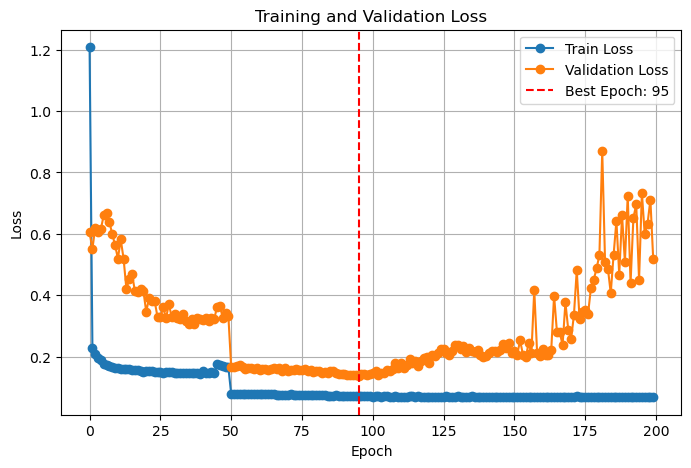

Training curves saved to checkpoints/training_curves.png
Best Epoch: 95
  Train Loss: 0.0710
  Val Loss:   0.1381
  Best Val (tracked): 0.1381


In [56]:
log_df = pd.read_csv(log_file)
best_row = log_df.loc[log_df["val_loss"].idxmin()]
best_epoch = int(best_row["epoch"])

plt.figure(figsize=(8,5))
plt.plot(log_df["epoch"], log_df["train_loss"], label="Train Loss", marker='o')
plt.plot(log_df["epoch"], log_df["val_loss"], label="Validation Loss", marker='o')
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f"Best Epoch: {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
curve_path = os.path.join(CHECKPOINT_DIR, "training_curves.png")
plt.savefig(curve_path)
plt.show()

print(f"Training curves saved to {curve_path}")
print(f"Best Epoch: {best_epoch}")
print(f"  Train Loss: {best_row['train_loss']:.4f}")
print(f"  Val Loss:   {best_row['val_loss']:.4f}")
print(f"  Best Val (tracked): {best_row['best_val_loss']:.4f}")
